# Importing packages

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import json

E:\WinPython\python-3.7.6.amd64\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
data = [json.loads(line) for line in open('News_Category_Dataset_v2.json', 'r')]
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200852 entries, 0 to 200851
Data columns (total 6 columns):
category             200852 non-null object
headline             200852 non-null object
authors              200852 non-null object
link                 200852 non-null object
short_description    200852 non-null object
date                 200852 non-null object
dtypes: object(6)
memory usage: 9.2+ MB


# Preprocessing

In [174]:
data = [json.loads(line) for line in open('News_Category_Dataset_v2.json', 'r')]
df = pd.DataFrame(data)
df.drop(df.loc[df['authors']==''].index, inplace=True)
df.drop(df.loc[df['headline']==''].index, inplace=True)
df.drop(df.loc[df['short_description']==''].index, inplace=True)
df['head_descr']=df.headline+' '+df.short_description
df = df[pd.notnull(df['head_descr'])]
df['year'] = pd.to_datetime(df.date).dt.year

In [175]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['head_descr'] = df['head_descr'].apply(cleanText)

# Exploratory Data Analysis (EDA)

In [176]:
df.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
head_descr           0
year                 0
dtype: int64

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148982 entries, 0 to 200847
Data columns (total 8 columns):
category             148982 non-null object
headline             148982 non-null object
authors              148982 non-null object
link                 148982 non-null object
short_description    148982 non-null object
date                 148982 non-null object
head_descr           148982 non-null object
year                 148982 non-null int64
dtypes: int64(1), object(7)
memory usage: 10.2+ MB


No null values

In [178]:
wordsCount = df['head_descr'].apply(lambda x: len(x.split(' '))).sum()
print("There are "+str(wordsCount)+" words in the head_descr colmun")

There are 4771193 words in the head_descr colmun


In [179]:
df.head()

,category,headline,authors,link,short_description,date,head_descr,year
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,"there were 2 mass shootings in teas last week,...",2018
1,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,hugh grant marries for the first time at age 5...,2018
2,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,jim carrey blasts 'castrato' adam schiff and d...,2018
3,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,julianna margulies uses donald trump poop bags...,2018
4,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26,morgan freeman 'devastated' that seual harassm...,2018


In [180]:
df.index = range(df.shape[0])

## Analysing category

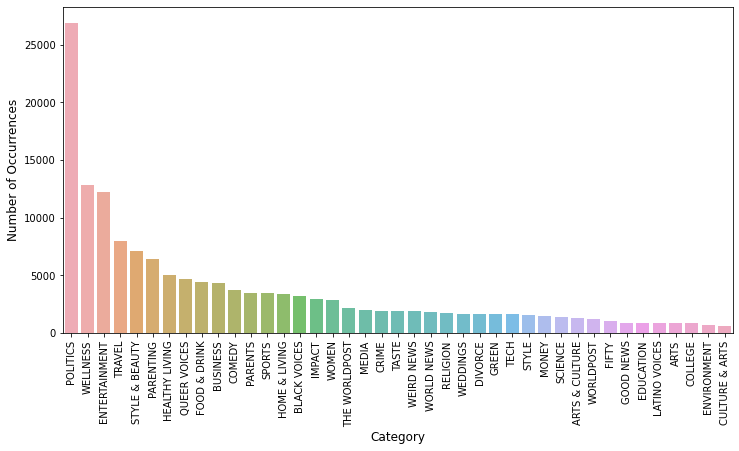

In [181]:
cnt_pro = df['category'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

Here we have a skewed distribution. Often this affects the classification algorithms. 

In [182]:
dfCategory = df['category'].value_counts()
print("Categories - absolute values")
print(df['category'].value_counts())

Categories - absolute values
POLITICS          26913
WELLNESS          12827
ENTERTAINMENT     12191
TRAVEL             8011
STYLE & BEAUTY     7111
PARENTING          6408
HEALTHY LIVING     5072
QUEER VOICES       4669
FOOD & DRINK       4413
BUSINESS           4320
COMEDY             3709
PARENTS            3491
SPORTS             3445
HOME & LIVING      3398
BLACK VOICES       3260
IMPACT             2920
WOMEN              2840
THE WORLDPOST      2198
MEDIA              1976
CRIME              1960
TASTE              1891
WEIRD NEWS         1890
WORLD NEWS         1824
RELIGION           1761
WEDDINGS           1703
DIVORCE            1695
GREEN              1682
TECH               1659
STYLE              1535
MONEY              1492
SCIENCE            1404
ARTS & CULTURE     1307
WORLDPOST          1242
FIFTY              1042
GOOD NEWS           917
EDUCATION           885
LATINO VOICES       877
ARTS                863
COLLEGE             860
ENVIRONMENT         670
CULTURE & A

In [183]:
print("Categories - percentage values")
print(round((df['category'].value_counts()/df['category'].count())*100,2))

Categories - percentage values
POLITICS          18.06
WELLNESS           8.61
ENTERTAINMENT      8.18
TRAVEL             5.38
STYLE & BEAUTY     4.77
PARENTING          4.30
HEALTHY LIVING     3.40
QUEER VOICES       3.13
FOOD & DRINK       2.96
BUSINESS           2.90
COMEDY             2.49
PARENTS            2.34
SPORTS             2.31
HOME & LIVING      2.28
BLACK VOICES       2.19
IMPACT             1.96
WOMEN              1.91
THE WORLDPOST      1.48
MEDIA              1.33
CRIME              1.32
TASTE              1.27
WEIRD NEWS         1.27
WORLD NEWS         1.22
RELIGION           1.18
WEDDINGS           1.14
DIVORCE            1.14
GREEN              1.13
TECH               1.11
STYLE              1.03
MONEY              1.00
SCIENCE            0.94
ARTS & CULTURE     0.88
WORLDPOST          0.83
FIFTY              0.70
GOOD NEWS          0.62
EDUCATION          0.59
LATINO VOICES      0.59
ARTS               0.58
COLLEGE            0.58
ENVIRONMENT        0.45
CULTURE &

An imbalanced classification problem is an example of a classification problem where the distribution of examples across the known classes is biased or skewed. As we can see, almost 50% of data are distributed in just 7 of 41 categories. This results in models that have poor predictive performance, specifically for the minority class.

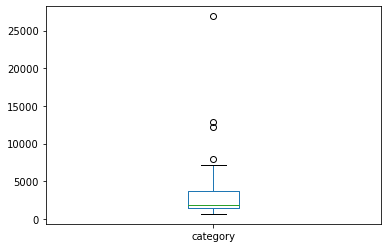

In [184]:
dfCategory.plot.box()

Boxplot shows the first four categories as outliers.

## Categories by year

In [185]:
count_series = df.groupby(['year', 'category']).size().sort_values().reset_index(name='count')

### Top 5 categories by year

In [186]:
dfTop5=count_series.sort_values(['year', 'count'],  ascending = [False, False]).groupby('year').head(5) 
dfTop5

,year,category,count
186,2018,POLITICS,3024
177,2018,ENTERTAINMENT,1706
111,2018,WORLD NEWS,481
105,2018,COMEDY,441
103,2018,QUEER VOICES,431
194,2017,POLITICS,10309
187,2017,ENTERTAINMENT,3154
173,2017,HEALTHY LIVING,1398
171,2017,WORLD NEWS,1343
169,2017,QUEER VOICES,1310


### Some useful information

Since 2015 POLITICS and ENTERTAINMENT are the TOP two categories. Until 2014 they didn't appear in the TOP 5 list.

WELLNESS was the TOP category until 2014. Since 2015 it didn't in the TOP 5 categories.

## Analysing Authors

In [187]:
dfAuthors = df['authors'].value_counts()
print("Top 20 Authors - absolute values")
print(dfAuthors.head(20))

Top 20 Authors - absolute values
Lee Moran                2423
Ron Dicker               1762
Reuters, Reuters         1562
Ed Mazza                 1194
Cole Delbyck             1140
Julia Brucculieri        1054
Andy McDonald            1001
Mary Papenfuss            974
Carly Ledbetter           962
Curtis M. Wong            890
Michelle Manetti          876
Nina Golgowski            868
Ellie Krupnick            860
Dana Oliver               831
David Moye                806
Sam Levine                778
James Michael Nichols     762
Bill Bradley              751
Michelle Persad           732
Igor Bobic                731
Name: authors, dtype: int64


In [188]:
print("Top 20 Authors - percentage values")
print(round((df['authors'].value_counts()/df['authors'].count())*100,2).head(20))

Top 20 Authors - percentage values
Lee Moran                1.63
Ron Dicker               1.18
Reuters, Reuters         1.05
Ed Mazza                 0.80
Cole Delbyck             0.77
Julia Brucculieri        0.71
Andy McDonald            0.67
Mary Papenfuss           0.65
Carly Ledbetter          0.65
Curtis M. Wong           0.60
Michelle Manetti         0.59
Nina Golgowski           0.58
Ellie Krupnick           0.58
Dana Oliver              0.56
David Moye               0.54
Sam Levine               0.52
James Michael Nichols    0.51
Bill Bradley             0.50
Michelle Persad          0.49
Igor Bobic               0.49
Name: authors, dtype: float64


In [189]:
print("Total Authors: "+str(df['authors'].count()))
print("50 Top Authors - percentage values: " + str(round(((df['authors'].value_counts().head(50)/
                                                           df['authors'].count())*100).sum(),2)) + 
      "% of the total")
print("100 Top Authors - percentage values: " + str(round(((df['authors'].value_counts().head(100)/
                                                           df['authors'].count())*100).sum(),2)) + 
      "% of the total")
print("500 Top Authors - percentage values: " + str(round(((df['authors'].value_counts().head(500)/
                                                           df['authors'].count())*100).sum(),2)) + 
      "% of the total")


Total Authors: 148982
50 Top Authors - percentage values: 25.02% of the total
100 Top Authors - percentage values: 35.0% of the total
500 Top Authors - percentage values: 55.0% of the total


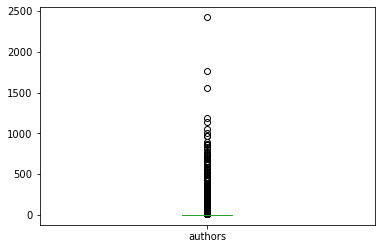

In [190]:
dfAuthors.plot.box()

## Author by year

In [191]:
count_series = df.groupby(['year', 'authors']).size().sort_values().reset_index(name='count')

### Top 5 authors by year

In [192]:
count_series.sort_values(['year', 'count'],  ascending = [False, False]).groupby('year').head(5) 

,year,authors,count
35182,2018,Lee Moran,634
35173,2018,Ed Mazza,402
35171,2018,Ron Dicker,390
35156,2018,Mary Papenfuss,306
35142,2018,Jenna Amatulli,269
35186,2017,Lee Moran,867
35181,2017,Mary Papenfuss,614
35176,2017,Ron Dicker,505
35172,2017,Ed Mazza,392
35167,2017,Caroline Bologna,341


### Some usefull information

Since 2015 Lee Moran is the TOP author with more than 20% publications over the second in the list.

Some authors left TOP 5 list since 2015, although some of them are in the highest overall position (e.g. Reuters)

In [193]:
dfReference = df.copy()
df.drop(['headline', 'authors', 'link', 'short_description', 'date', 'year'], axis=1, inplace=True)
df.head(10)

,category,head_descr
0,CRIME,"there were 2 mass shootings in teas last week,..."
1,ENTERTAINMENT,hugh grant marries for the first time at age 5...
2,ENTERTAINMENT,jim carrey blasts 'castrato' adam schiff and d...
3,ENTERTAINMENT,julianna margulies uses donald trump poop bags...
4,ENTERTAINMENT,morgan freeman 'devastated' that seual harassm...
5,ENTERTAINMENT,donald trump is lovin' new mcdonald's jingle i...
6,ENTERTAINMENT,what to watch on amazon prime that’s new this ...
7,ENTERTAINMENT,mike myers reveals he'd 'like to' do a fourth ...
8,ENTERTAINMENT,what to watch on hulu that’s new this week you...
9,ENTERTAINMENT,justin timberlake visits teas school shooting ...


# Exporting DataFrame to be used by classification scripts

In [195]:
df.to_csv('ds_cat_head_descr.csv', index=False)